# Laplace Approximation

In [ ]:
%pip install lightning-uq-box

The implementation is a wrapper around a model from the fantastic [Laplace library](https://aleximmer.github.io/Laplace/) so all the available options for subnet strategies can be found in their docs.

## Imports

In [3]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from laplace import Laplace
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import (
    DeterministicClassification,
    LaplaceClassification,
)
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_training_metrics,
    plot_two_moons_data,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [4]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [5]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [6]:
dm = TwoMoonsDataModule(batch_size=128)

X_train, Y_train, X_test, Y_test, test_grid_points = (
    dm.X_train,
    dm.Y_train,
    dm.X_test,
    dm.Y_test,
    dm.test_grid_points,
)

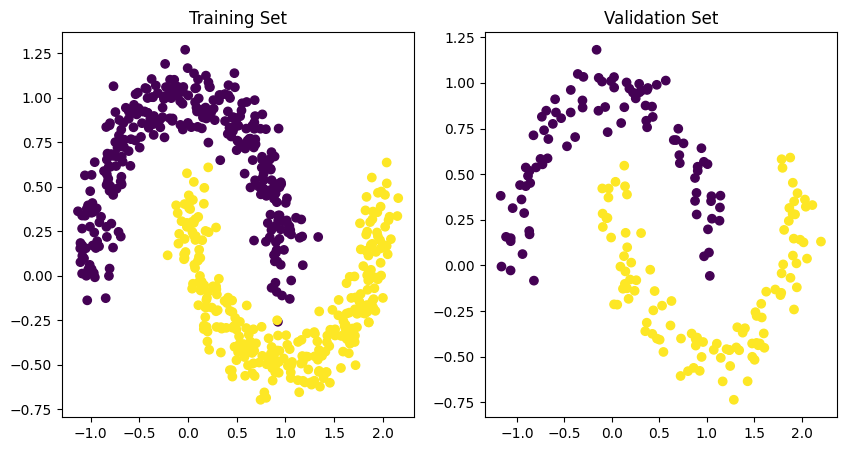

In [7]:
fig = plot_two_moons_data(X_train, Y_train, X_test, Y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [8]:
network = MLP(n_inputs=2, n_hidden=[50, 50], n_outputs=2, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

For the Laplace model, we first train a plain deterministic model to obtain a MAP estimate of the weights via the standard MSE loss. Subsequently, we fit the Laplace Approximation to obtain an estimate of the epistemic uncertainty for predictions.

In [10]:
deterministic_model = DeterministicClassification(
    model=network,
    optimizer=partial(torch.optim.Adam, lr=1e-2),
    loss_fn=torch.nn.CrossEntropyLoss(),
)

## Trainer

Now that we have a LightningDataModule and base model, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [11]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [12]:
trainer.fit(deterministic_model, dm)

Missing logger folder: /tmp/tmptngugye7/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.8 K 
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

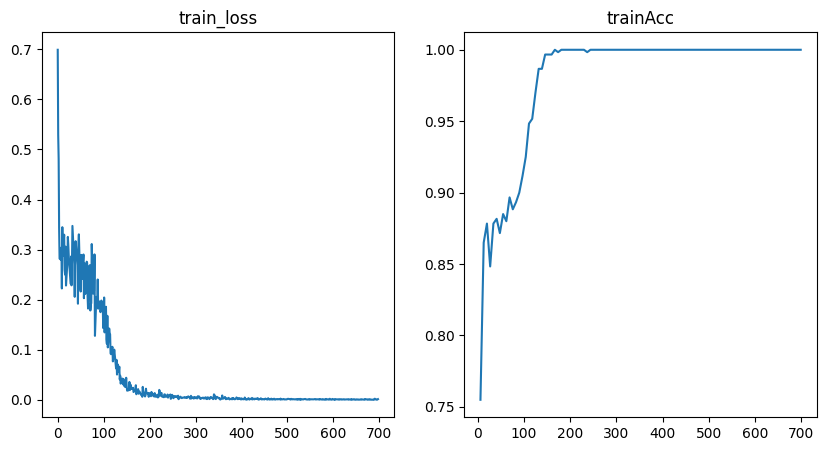

In [14]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainAcc"]
)

## Fit Laplace
We will utilize the great [Laplace Library](https://aleximmer.github.io/Laplace/) that allows you to define different flavors of Laplace approximations. For small networks like in this example, one can fit the Laplace approximation over all weights, but this is not feasible for large million-parameter networks. In those cases, on can resort to a "last-layer" approximation, where only the last layer weights are stochastic, while all other weights are deterministic. This behavior is controlled with the `subset_of_weights` parameter. This is chosen in combination with the structure of the Hessian that is fitted, see the `hessian_structure` parameter. Check their documentation for details. The Lightning-UQ-Box provides a wrapper so that the workflow is the same as with any other implemented UQ-Method.

In [15]:
la = Laplace(
    deterministic_model.model,
    "classification",
    subset_of_weights="last_layer",
    hessian_structure="full",
)


laplace_model = LaplaceClassification(laplace_model=la)

trainer = Trainer(default_root_dir=my_temp_dir)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile. The Laplace wrapper module will conduct the Laplace fitting procedure automatically before making the first prediction and will use one of the available prediction procedures. Originally, this was done through sampling and multiple forward passes, however, [Immer et al. 2021](https://arxiv.org/abs/2008.08400) showed that a linearization of the model achieves better performance in practice:
$f_{\theta}(x)=f_{\theta_{MAP}}(x)+ J_{\theta_{MAP}}(\theta-\theta_{MAP})$
and that is the current default implementation. However, arguments can be passed to the class or the individual predict step to choose between the following procedures of sampling as `pred_type="glm"` (linearization) or `pred_type="nn"` (sampling).

In [16]:
trainer.test(laplace_model, dm)

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          testAcc          │    0.9950000047683716     │
│      testCalibration      │    0.08247579634189606    │
│  testEmpirical Coverage   │    0.9950000047683716     │
│         test_loss         │    0.3616868853569031     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3616868853569031,
  'testAcc': 0.9950000047683716,
  'testCalibration': 0.08247579634189606,
  'testEmpirical Coverage': 0.9950000047683716}]

In [20]:
preds = laplace_model.predict_step(test_grid_points)

## Evaluate Predictions

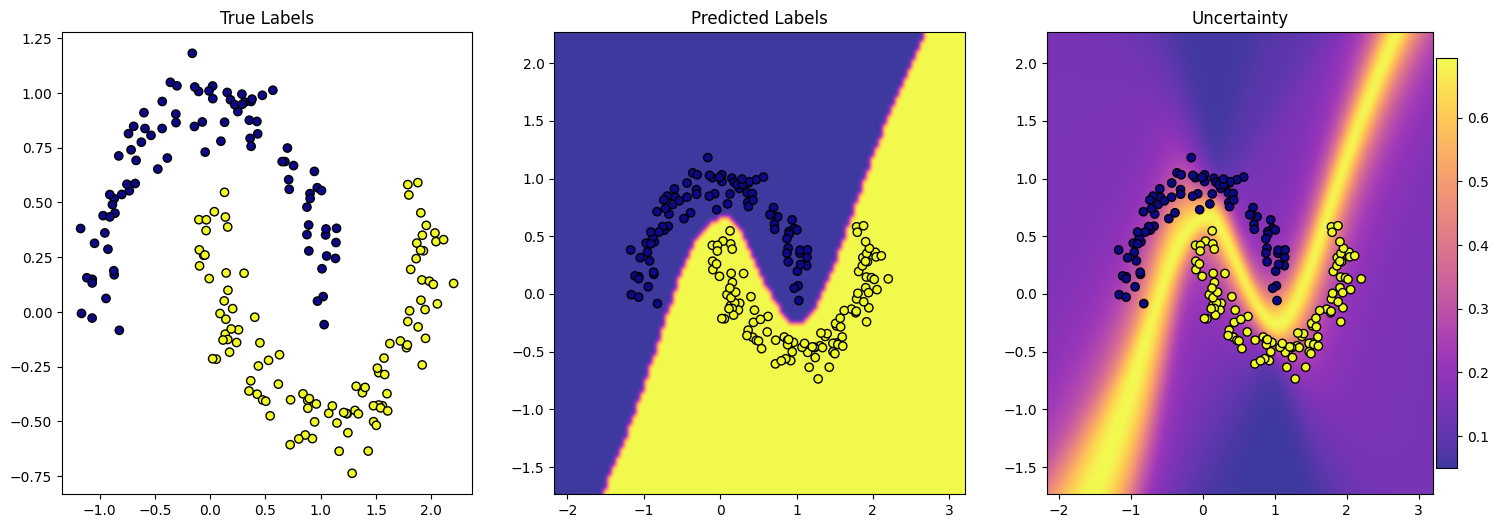

In [21]:
fig = plot_predictions_classification(
    X_test, Y_test, preds["pred"].argmax(-1), test_grid_points, preds["pred_uct"]
)

## Additional Resource

[Daxberger et al. 2020](https://arxiv.org/abs/2010.14689) introduced a subnetwork selection strategy that turns selected weights "Bayesian" while keeping the rest of the network deterministic and show performance on par with deep ensembles.